### What drives the success of lower budget movies? 
Can we use linear regression to identify the features of lower budget movies that drive success? How do success drivers differ when success is being defined by revenues versus recognition (in the form of Oscar nominations)?  

Diana Lam  
January 2016 

In [123]:
# storing
import pickle

# exploratory analysis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import re
from pandas.tools.plotting import scatter_matrix
import math

# regression
from patsy import dmatrices
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn import cross_validation
from sklearn.metrics import mean_squared_error
import scipy.stats as stats
from sklearn.preprocessing import PolynomialFeatures

from pprint import pprint

%matplotlib inline

### Parse movie data retrieved from Box Office Mojo

First, let's load the movie data into a dataframe and do some column cleanup.

In [194]:
with open('data/all-movies-data3.pkl', 'r') as picklefile:
    all_movies_data = pickle.load(picklefile)

movies = pd.DataFrame(all_movies_data)

In [196]:
# rename cols
movies.rename(columns = {'1-title': 'title', 
                         '2-release_date': 'release_date', 
                         '3-closing_date': 'closing_date'}, inplace = True)

# drop unnecessary cols
movies.drop(['url', 'distributor'], axis = 1, inplace = True)

In [43]:
# delete or move to later 
by_genre = movies.groupby('genre')

Next, let's aggregate the given parameters for some of the categorical features (season, genre, MPAA rating) into more succinct paramaters for use in the analysis.

In [217]:
def recat(df, func, new_col, old_col):
    '''Recategorize variable in new column based on data in old col
    and provided function. 
    Args: 
    df -- data frame
    func -- function to apply
    new_col (str) -- name of new column (to store result of function)
    old_col (str) -- name of old column (on which to apply function)
    '''
    df[new_col] = df.loc[:, old_col].apply(func) 

# add movie seasons; rationale from http://www.boxofficemojo.com/seasonal/?chart=byseason
def get_season(date):
    '''Return season given month as int.'''
    months = (range(1, 13))
    seasons = ['winter', 'winter', 'spring', 'spring', 
           'summer', 'summer', 'summer', 'summer', 
           'fall', 'fall', 'holiday', 'holiday']
    seasons = dict(zip(months, seasons))
    try:
        return seasons[date.month]
    except:
        return ''

# map raw genres to simple genres
def get_simple_genre(g):
    '''Recategorize raw genre into simple genre.'''
    raw_genres = tuple(by_genre.count().index)
    simple_genres = ['Act_Adven', 'Act_Adven', 'Act_Adven', 'Act_Adven', 'Act_Adven', 'Act_Adven', 
                 'Act_Adven', 'Act_Adven', 'Act_Adven', 'Act_Adven', 
                 'Animation', 'Comedy', 'Comedy', 'Comedy', 'Other', 
                 'Crime_Thriller', 'Crime_Thriller', 'Crime_Thriller', 'Crime_Thriller', 
                 'Documentary', 'Drama', 'Drama', 'Family', 'Family', 'Family', 'Fantasy_Scifi', 'Fantasy_Scifi', 
                 'Fantasy_Scifi', 'Foreign', 'Foreign', 'Foreign', 'Historical', 'Historical', 
                 'Horror', 'Horror', 'Horror', 'Other', 'Musical', 'Musical', 'None', 
                 'Historical', 'Historical', 'Historical', 'Historical', 'Historical', 
                 'Romance', 'Romance', 'Romance', 'Romance', 'Fantasy_Scifi', 'Fantasy_Scifi', 
                 'Fantasy_Scifi', 'Fantasy_Scifi', 'Fantasy_Scifi', 'Fantasy_Scifi', 
                 'Fantasy_Scifi', 'Sports', 'Sports', 'Sports', 'Sports',  'Crime_Thriller', 
                 'None', 'War', 'War', 'War', 'Western', 'Western']
    genres = dict(zip(raw_genres, simple_genres))
    try:
        return genres[g]
    except:
        return ''

# clean up ratings
def get_clean_rating(r):
    rm_ratings = ['Unknown', 'Unrated', 'None', 'Not Yet Rated']
    return '' if r in rm_ratings else r

In [200]:
recat(movies, get_season, 'season', 'release_date')
recat(movies, get_clean_rating, 'clean_rating', 'rating')
recat(movies, get_simple_genre, 'new_genre', 'genre')

### Subset data to movies with budget information and parse

Since we're interested in budget data, let's check to see how many movies of the 16,100 total movies have budget data.

In [126]:
movies.budget.count()

2875

Only 2,874 out of 16,100 movies have budget data. That's only 17.9% of the entire dataset! Let's take a closer look at movies with budget data.

In [208]:
# drop movies without budget data 
only_budget = movies[pd.notnull(movies['budget'])]

In [209]:
# adjust budgets to 2015 dollars 
def get_infl_rate(startyear, endyear):
    '''Return inflation rate to 2015 dollars. 
    Args:
    startyear (float) -- start year
    endyear (int) -- end year
    Returns:
    infl (float) -- inflation rate
    '''
    cpi = pd.read_csv('data/cpi-data.csv')
    cpi.set_index('YEAR', inplace = True)
    if endyear > 2015:
        return float('NaN')
    else:
        try:
            cpiend = float(cpi.loc[endyear, 'AVE.'])
            cpistart = float(cpi.loc[int(startyear), 'AVE.'])
            infl = ((cpiend - cpistart) / cpistart) 
            return (1.0 + infl)
        except:
            return float('NaN')
    
def add_infl_rate(df):
    # add release year
    try:
        df['release_year'] = df.loc[:,'release_date'].apply(lambda x: x.year)
    except:
        df['release_year'] = None
    df['infl_rate'] = df.loc[:,'release_year'].apply(get_infl_rate, args=(2015,))
    
def add_adj_budget(df):
    df['budget_adj'] = df.loc[:, 'budget'] * df.loc[:, 'infl_rate']
    df['budget_adj'] = df.loc[:,'budget_adj'].fillna(0.0).astype(int)

# add roi
def get_dom_roi(df):
    df['dom_roi'] = (df.loc[:,'dom_total_gross'] - df.loc[:,'budget'])/ df.loc[:,'budget']

In [212]:
add_infl_rate(only_budget)
add_adj_budget(only_budget)
get_dom_roi(only_budget)

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-

Let's look at lower budget movies that have been released since 1980. 

In [213]:
# set assumptions
budget_threshold = 30000000
year_threshold = '1980'

In [214]:
# get only low budget films since 1980
low_budget = only_budget[only_budget['budget_adj'] < budget_threshold]
low_budget = low_budget[low_budget['budget_adj'] > 0] 
m = low_budget[low_budget['release_date'] >= datetime.strptime(year_threshold, '%Y')]

### Parse oscars data retrieved from Newsday

In [ ]:
with open('data/oscars-data.pkl', 'r') as picklefile:
     oscars = pickle.load(picklefile)
        
oscars = pd.DataFrame(oscars)

# get actors
actors = oscars[oscars.category.str.contains('Act')]
actors.year = actors.year.apply(int)

# get directors 
dirs = oscars[oscars.category == 'Best Director']
dirs.year = dirs.year.apply(int)

def count_nominations(df, person, year):
    """Total nominations before a given year for an actor or director.
    args:
        df (dataframe): data frame
        person (string): director or actor name name
        year (int): cutoff year
    returns:
        (int) number of nominations
    """
    return df[df.person == person][df.year < year].shape[0]

In [224]:
# add actor oscar nominations up to movie release year
m['actor_noms'] = m.apply(
    lambda row: sum(map(lambda a: count_nominations(actors, a, row.release_year), row.actors)), axis=1)

# add director oscar nominations up to movie release year
m['dir_noms'] = m.apply(
    lambda row: sum(map(lambda d: count_nominations(dirs, d, row.release_year), row.director)), axis=1)

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


### Explore high-level features

Now that our base data has been parsed, let's explore the high-level relationship between movie success and our continuous features.

**Domestic total gross vs. features**

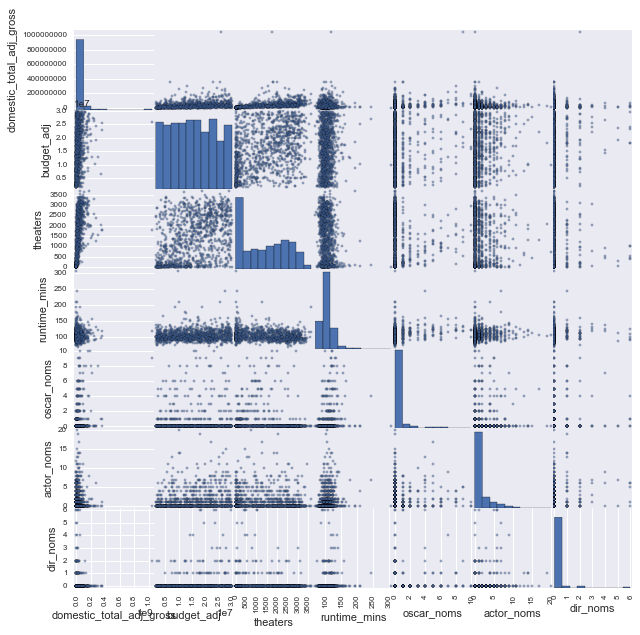

In [226]:
gross_features = ['domestic_total_adj_gross', 'budget_adj', 
            'theaters', 'runtime_mins', 'oscar_noms', 
            'actor_noms', 'dir_noms']
scatter_matrix(m[gross_features], figsize = (10, 10), alpha = 0.5, diagonal='hist')
plt.show()

**Oscar nominatons vs. features**

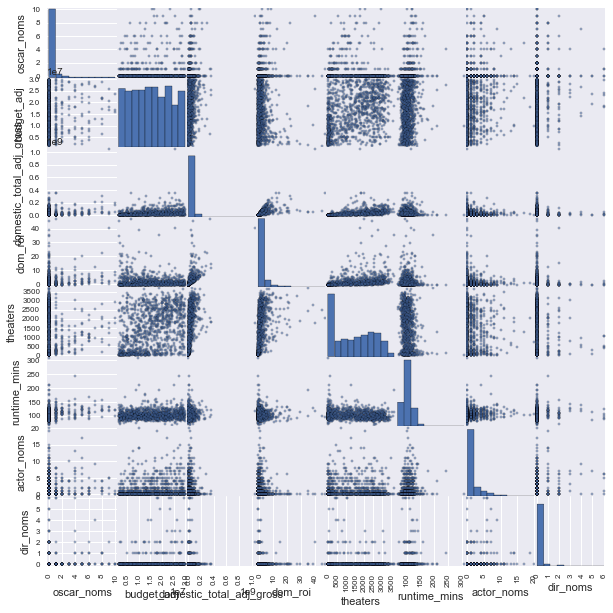

In [232]:
oscars_features = ['oscar_noms', 'budget_adj', 'domestic_total_adj_gross', 'dom_roi',
            'theaters', 'runtime_mins', 'actor_noms', 'dir_noms']
scatter_matrix(m[oscars_features], figsize = (10, 10), alpha = 0.5, diagonal='hist')
plt.show()

From these initial scatter plots, we can see that domestic adjusted total gross, domestic ROI, total oscar nominations, actor oscar nominations, and director oscar nominations are not normally distributed and will need to be normalized by taking the logarithm. Theaters and runtime also have skewed distributions, but normalization of these features will depend on model performance.

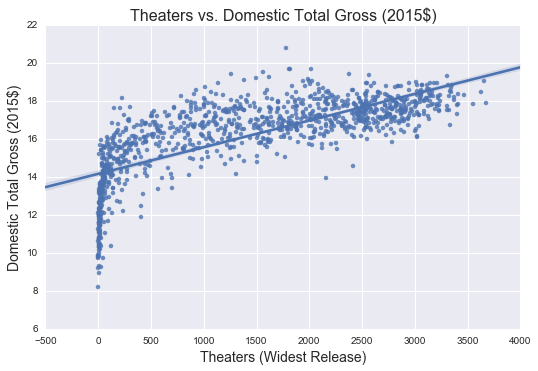

In [102]:
sns.lmplot('theaters', 'dadj_gross_log', newer_movies, size=5, aspect=1.5)
plt.title('Theaters vs. Domestic Total Gross (2015$)', fontsize=16)
plt.xlabel('Theaters (Widest Release)', fontsize=14)
plt.ylabel('Domestic Total Gross (2015$)', fontsize=14)
plt.savefig('presentation/lmplot-theaters.png')
plt.show()

### Conduct additional features manipulation for models

Now that we have an idea of the features that need to be normalized, let's transform our dependent and independent data to satisfy the assumptions of our linear regression model. This section also includes additional transformations that were found to have a significantly positive impact on the predictive power of the model after initial model testing.

**Oscar nominations model**  
Following several iterations of the oscar nominations model, I found that there was a significant correlation between the following features and oscar nominations:  
* MPAA rating: rated R vs. not R
* release season: holiday (November - December) or winter (January - February) vs. other seasons
* genre: drama, foreign, historical, or war vs. other genres

The following functions recategorize the features in these categories and normalizes the skewed features discussed above.

In [233]:
# seasons: split into holiday, winter, and other
def recat_seasons(season):
    rm_seasons = ['spring', 'summer', 'fall']
    return 'other' if season in rm_seasons else season

# genres: split into drama, foreign, historical, war, western, other
def recat_genre(genre):
    keep_genres = ['Drama', 'Foreign', 'Historical', 'War']
    return genre if genre in keep_genres else 'other'

# log transform
def log_transform(stat):
    if stat > 0:
        return math.log(stat)
    elif stat == 0:
        return math.log(stat + .001)
    else:
        return math.log(1 + stat)

In [234]:
# recategorize rating, season, and genre based on first iterations of model 
recat(m, split_r_rating, 'r_rating', 'rating')
recat(m, recat_seasons, 'hw_season', 'season')
recat(m, recat_genre, 'recat_genre', 'new_genre')

# normalize oscar features and create interaction features 
recat(m, log_transform, 'oscar_noms_log', 'oscar_noms')
recat(m, log_transform, 'actor_noms_log', 'actor_noms')
recat(m, log_transform, 'dir_noms_log', 'dir_noms')
m['actdir_noms'] = m.actor_noms + m.dir_noms
recat(m, log_transform, 'actdir_noms_log', 'actdir_noms')

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


**Gross revenues model**  
Like in the oscar nominations model, I found the following features and their subsets to be statistically significant in having predictive power in the revenues model:  
* rating: NC-17 vs. G, PG, PG-13, or R
* genres: horror, drama, foreign, or family vs. others

The functions below recategorize my features into these categories for my optimized model. I also normalize the gross revenues and theaters features as discussed in the previous section. 

In [236]:
def roi_rating(rating):
    rm_rating = ['', 'NC-17']
    return 'other' if rating in rm_rating else rating

def roi_genres(genre):
    keep_genres = ['Horror', 'Drama', 'Foreign', 'Family']
    return genre if genre in keep_genres else 'other'

In [237]:
recat(m, roi_rating, 'roi_rating', 'clean_rating')
recat(m, roi_genres, 'roi_genre', 'new_genre')
recat(m, log_transform, 'theaters_log', 'theaters')
recat(m, log_transform, 'dom_roi_log', 'dom_roi')
recat(m, lambda x: x**2, 'theaters2', 'theaters')
recat(m, lambda x: x**3, 'theaters3', 'theaters')
recat(m, log_transform, 'dadj_gross_log', 'domestic_total_adj_gross')

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


### Split data for cross-validation

In [239]:
# assumptions
trainandcv_max = 2012.0
testyr = [2013.0, 2014.0, 2015.0]

In [241]:
keep = ['release_year', 'budget', 'budget_adj', 'oscar_noms', 'oscar_noms_sq', 'oscar_noms_log', 'runtime_mins', 
        'theaters', 'r_rating', 'hw_season', 'recat_genre', 'theaters_log', 'theaters2', 'theaters3', 
        'dom_roi', 'dom_roi_log', 'actor_noms', 'dir_noms', 'actor_noms_log', 'dir_noms_log', 'actdir_noms_log', 
        'actdir_noms', 'domestic_total_adj_gross', 'dadj_gross_log', 'roi_genre', 'roi_rating']

In [242]:
# set up dummy variables for categorical features 
temp = newer_movies[keep]
temp.dropna(inplace = True)
dummies = pd.get_dummies(temp)
formodel = sm.add_constant(dummies)

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


In [245]:
# split into train and test
train = formodel[formodel['release_year'] <= trainandcv_max]
test = formodel[formodel['release_year'].isin(testyr)]

In [246]:
# check if they add up
print train.shape[0] + test.shape[0] == formodel.shape[0]
print train.shape[0], test.shape[0] 

# check percentages
print 'train as % of total: ', float(train.shape[0]) / float(formodel.shape[0])
print 'test as % of total: ', float(test.shape[0]) / float(formodel.shape[0])

True
961 142
train as % of total:  0.871260199456
test as % of total:  0.128739800544


### Set up functions for regression

In [288]:
def get_xy(features, ind, df):
    '''Get X and y for use in skl linear regression.'''
    X = df[features]
    y = df[ind]
    return X, y

def regress_skl(X, y):  
    '''Fit linear regression model using skl.
    Prints rsq and intercept and returns model.'''
    # fit model
    m = LinearRegression()
    m.fit(X, y)
    coefs = zip(X.columns, m.coef_)
    rsq = m.score(X, y)
    intercept = m.intercept_
    print 'rsquared: ', rsq
    print 'intercept: ', intercept
    return m

def test_model(model, X_test, y_test, X, y):
    '''Generate predicted values for test set and compute mean squared
    error vs. training set.
    Returns for the test set: residuals, mse, ypred values. 
    Args:
    model -- fitted linear regression model to use for predictions
    X, y -- X, y of training set
    X_test, y_test = X, y of test set 
    '''
    test_ypred = model.predict(X_test)
    test_resid = y_test - test_ypred
    test_mse = mean_squared_error(y_test, test_ypred)
    
    train_ypred = model.predict(X)
    train_resid = y - train_ypred
    train_mse = mean_squared_error(y, train_ypred)
    print 'train mse: ', train_mse, 'vs. test mse: ', test_mse
    return test_resid, test_mse, test_ypred

def plot_qq(resid):
    '''Create QQ plot given model residuals.'''
    stats.probplot(resid, dist="norm", plot=plt)
    plt.show()

def cross_validate_mse(X, y, folds):
    '''Cross validate model. Returns mean mse.'''
    scores = cross_validation.cross_val_score(LinearRegression(), X, y, scoring='mean_squared_error', cv=folds)
    return scores.mean()

def cross_validate(X, y, folds):
    '''Cross validate model. Returns mean r-squared.'''
    scores = cross_validation.cross_val_score(LinearRegression(), X, y, cv=folds)
    return scores.mean()

In [251]:
def get_rsq4plot(features, ind, df):
    """Get list of adjusted rsquares based on number
    of features included.
    Args:
    features (list) -- list of features
    ind (str) -- column name of independent var
    df (df) -- df
    Returns:
    list of (num features, adjusted r squared tuples)
    """
    adj_rsqs = []
    feats = []
    for i in range(1, len(features)):
        feats.append(features[:i+1])
    for feat in feats:
        X, y = get_xy(feat, ind, df)
        model = sm.OLS(y, X)
        model = model.fit()
        adj_rsqs.append(model.rsquared_adj)
    return (map(lambda x: len(x), feats), adj_rsqs)  

def get_mse4plot(features, ind, df):
    """Get list of average mse from crossvalidation based on number
    of features included.
    Args:
    features (list) -- list of features
    ind (str) -- column name of independent var
    df (df) -- df
    Returns:
    list of (num features, average mse tuples); note that 
    first pair is for the intercept only 
    """
    avg_mse = []
    feats = []
    for i in range(1, len(features)):
        feats.append(features[:i+1])
    for feat in feats:
        X, y = get_xy(feat, ind, df)
        avg_mse.append(cross_validate_mse(X, y, 5))
    return (map(lambda x: len(x), feats), map(lambda x: abs(x), avg_mse))    

### Run domestic total gross model

In [279]:
features_gross = ['const', 
            'budget_adj', \
            'theaters', 
            'runtime_mins', 
            'actdir_noms', 
            'hw_season_holiday',
            'roi_genre_Horror', 
            'roi_rating_G', 'roi_rating_PG', 'roi_rating_PG-13', 'roi_rating_R']                 
ind = 'dadj_gross_log'
X, y = get_xy(features_gross, ind, train)
gross = sm.OLS(y, X)
gross = gross.fit()
gross.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         dadj_gross_log   R-squared:                       0.586
Model:                            OLS   Adj. R-squared:                  0.581
Method:                 Least Squares   F-statistic:                     134.3
Date:                Sun, 31 Jan 2016   Prob (F-statistic):          4.44e-174
Time:                        23:05:52   Log-Likelihood:                -1660.4
No. Observations:                 961   AIC:                             3343.
Df Residuals:                     950   BIC:                             3396.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------------
const                11.5008      0.407     28.264      0.000        10.702    12.299
budget_adj         1.497e-08   6.42e-09      2.333      0.020      2.38e-09  2.76e-08
theaters              0.0015    5.3e-05     27.847      0.000         0.001     0.002
runtime_mins          0.0121      0.003      4.455      0.000         0.007     0.017
actdir_noms           0.0385      0.019      2.003      0.045         0.001     0.076
hw_season_holiday     0.6086      0.126      4.811      0.000         0.360     0.857
roi_genre_Horror     -0.3367      0.156     -2.155      0.031        -0.643    -0.030
roi_rating_G          0.9712      0.439      2.210      0.027         0.109     1.833
roi_rating_PG         0.8569      0.294      2.919      0.004         0.281     1.433
roi_rating_PG-13      1.0166      0.271      3.748      0.000         0.484     1.549
roi_rating_R          1.1495      0.258      4.454      0.000         0.643     1.656
==============================================================================
Omnibus:                       56.736   Durbin-Watson:                   2.062
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               86.731
Skew:                          -0.472   Prob(JB):                     1.47e-19
Kurtosis:                       4.129   Cond. No.                     2.57e+08
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.57e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [280]:
# get average rsquared and mse of cross-validation sets 
print 'avg rsq: ', cross_validate(X, y, 5)
print 'avg mse: ', cross_validate_mse(X, y, 5)

avg rsq:  0.572850395597
avg mse:  -1.90262465727


Let's run on our test set.

In [289]:
Xtest, ytest = get_xy(features_gross, ind, test)
gresid, gmse, gpred = test_model(gross, Xtest, ytest, X, y)

train mse:  1.85480725064 vs. test mse:  1.16833421733


MSE of 1.17 on the test set vs. 1.85 on the training set--the model actually performed better on the training set than the test set!

In [259]:
# compare actual vs. predictions
d_gross = {'pred': gpred, 'actual': ytest}
pd.DataFrame(d_gross).head()

,actual,pred
27,17.757011,17.367749
81,16.766172,17.353102
229,18.035692,18.353451
333,13.708816,14.017488
446,16.506849,18.364590


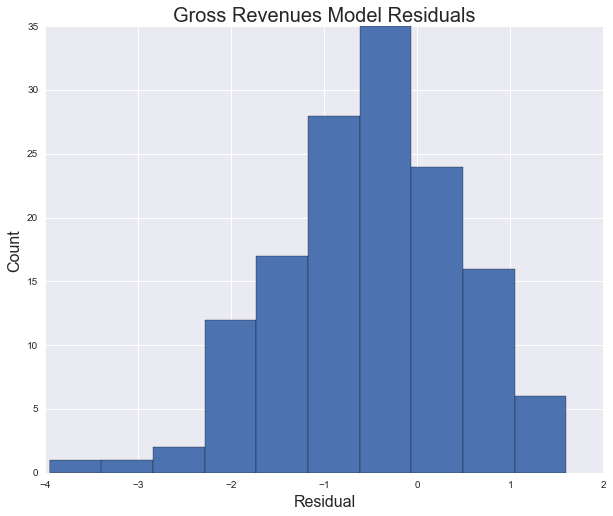

In [193]:
# plot historgram of residuals 
plt.figure(figsize=(10, 8))
plt.hist(gresid.values)
plt.title('Gross Revenues Model Residuals', fontsize=20)
plt.xlabel('Residual', fontsize=16)
plt.ylabel('Count', fontsize=16)
plt.savefig('presentation/gross-resid-hist.png')
plt.show()

In [255]:
numfeat_gross, mses_gross = get_mse4plot(features_gross, 'dadj_gross_log', train)
numfeat_gross2, rsqs_gross = get_rsq4plot(features_gross, 'dadj_gross_log', train)

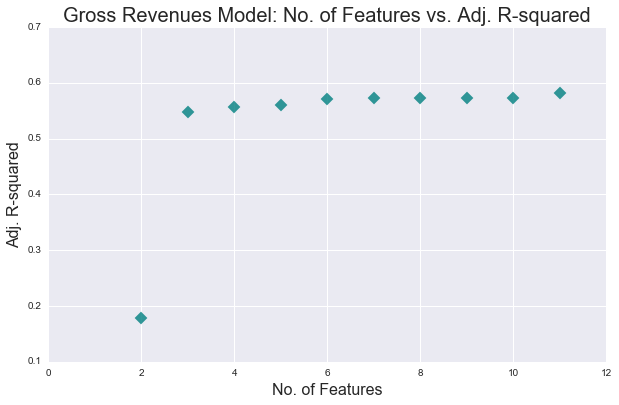

In [261]:
# plot rsq vs. num features
plt.figure(figsize=(10, 6))
plt.scatter(numfeat_gross2, rsqs_gross, s=75, color='teal', marker='D', alpha=0.8)
plt.title('Gross Revenues Model: No. of Features vs. Adj. R-squared', fontsize=20)
plt.xlabel('No. of Features', fontsize=16)
plt.ylabel('Adj. R-squared', fontsize=16)
plt.savefig('presentation/gross-plot.png')
plt.show()

train mse:  1.85480725064 vs. val mse:  1.85480725064


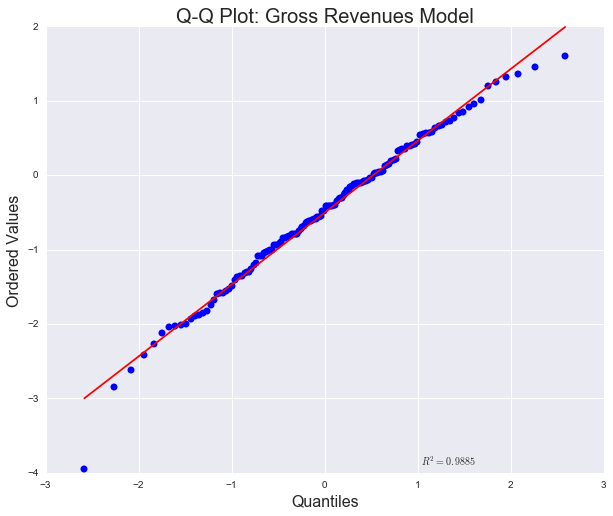

In [293]:
gtrain_resid, _, _ = validate(gross, X, y, X, y)

plt.figure(figsize=(10, 8))
stats.probplot(gresid, dist="norm", plot=plt)
plt.title('Q-Q Plot: Gross Revenues Model', fontsize=20)
plt.xlabel('Quantiles', fontsize=16)
plt.ylabel('Ordered Values', fontsize=16)
# plt.savefig('presentation/qq-gross.png')
plt.show()

### Run oscar nominations model

In [294]:
features_oscars = ['const', 
            'r_rating_R', \
            'recat_genre_Drama', 'recat_genre_Foreign', 'recat_genre_Historical', 'recat_genre_War', \
            'hw_season_holiday', \
            'theaters3', \
            'runtime_mins', 
            'dom_roi_log', 
            'actor_noms_log']

ind = 'oscar_noms_log'
X, y = get_xy(features_oscars, ind, train)
oscars = sm.OLS(y, X)
oscars = oscars.fit()
oscars.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         oscar_noms_log   R-squared:                       0.285
Model:                            OLS   Adj. R-squared:                  0.277
Method:                 Least Squares   F-statistic:                     37.87
Date:                Sun, 31 Jan 2016   Prob (F-statistic):           9.16e-63
Time:                        23:12:30   Log-Likelihood:                -2129.5
No. Observations:                 961   AIC:                             4281.
Df Residuals:                     950   BIC:                             4335.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------------------
const                     -6.9154      0.510    -13.564      0.000        -7.916    -5.915
r_rating_R                 0.4466      0.149      2.988      0.003         0.153     0.740
recat_genre_Drama          0.8354      0.221      3.776      0.000         0.401     1.270
recat_genre_Foreign        2.4212      0.436      5.554      0.000         1.566     3.277
recat_genre_Historical     1.3832      0.367      3.770      0.000         0.663     2.103
recat_genre_War            3.0701      1.010      3.039      0.002         1.087     5.053
hw_season_holiday          1.4102      0.207      6.804      0.000         1.003     1.817
theaters3              -5.253e-11   8.79e-12     -5.979      0.000     -6.98e-11 -3.53e-11
runtime_mins               0.0127      0.005      2.801      0.005         0.004     0.022
dom_roi_log                0.4657      0.043     10.887      0.000         0.382     0.550
actor_noms_log             0.0761      0.021      3.647      0.000         0.035     0.117
==============================================================================
Omnibus:                      201.124   Durbin-Watson:                   1.868
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              358.442
Skew:                           1.278   Prob(JB):                     1.46e-78
Kurtosis:                       4.556   Cond. No.                     1.67e+11
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.67e+11. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [295]:
# get average rsquared and mse of cross-validation sets 
print 'avg rsq: ', cross_validate(X, y, 5)
print 'avg mse: ', cross_validate_mse(X, y, 5)

avg rsq:  0.232942424407
avg mse:  -5.13463730161


In [299]:
# test on test set 
Xtest_o, ytest_o = get_xy(features_oscars, ind, test)
oresid, omse, opred = test_model(oscars4, Xtest_o, ytest_o, X, y)

train mse:  4.95522709149 vs. test mse:  5.31485913167


In [302]:
# compare actual vs. predictions
d_oscars = {'pred': opred, 'actual': ytest_o}
pd.DataFrame(d_oscars).head()

,actual,pred
27,-6.907755,-5.719798
81,-6.907755,-6.494041
229,-6.907755,-7.970668
333,-6.907755,-7.275241
446,-6.907755,-6.640695


In [303]:
numfeat_o, mses_o = get_mse4plot(features_oscars, 'oscar_noms_log', train)
numfeat2_o, rsqs_o = get_rsq4plot(features_oscars, 'oscar_noms_log', train)

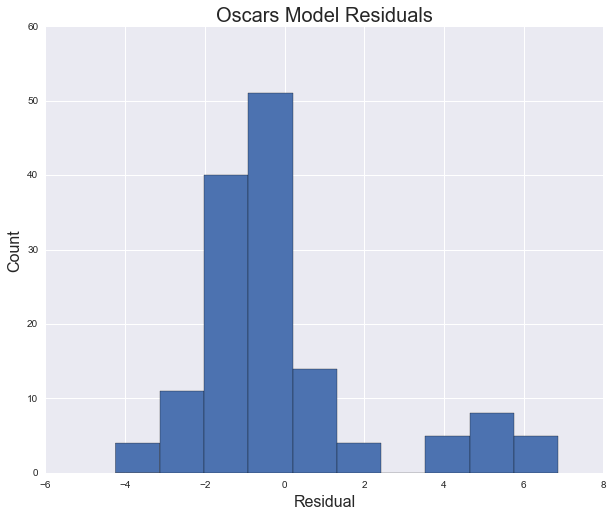

In [304]:
plt.figure(figsize=(10, 8))
plt.hist(oresid.values)
plt.title('Oscars Model Residuals', fontsize=20)
plt.xlabel('Residual', fontsize=16)
plt.ylabel('Count', fontsize=16)
plt.savefig('presentation/oscars-resid-hist.png')
plt.show()

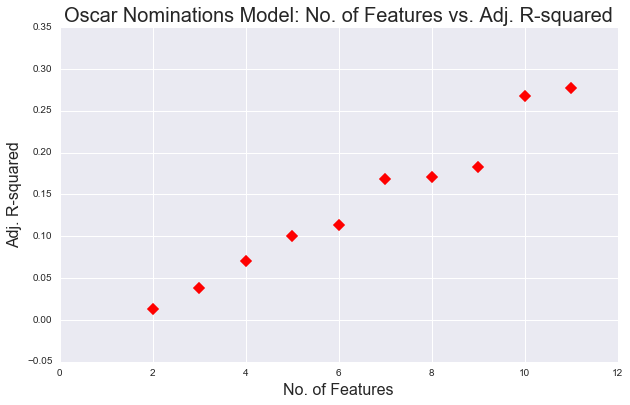

In [272]:
plt.figure(figsize=(10, 6))
plt.scatter(numfeat_o, rsqs_o, s=70, color='red', marker='D')
plt.title('Oscar Nominations Model: No. of Features vs. Adj. R-squared', fontsize=20)
plt.xlabel('No. of Features', fontsize=16)
plt.ylabel('Adj. R-squared', fontsize=16)
plt.savefig('presentation/oscar-rsq.png')
plt.show()

train mse:  4.92342826068 vs. val mse:  4.92342826068


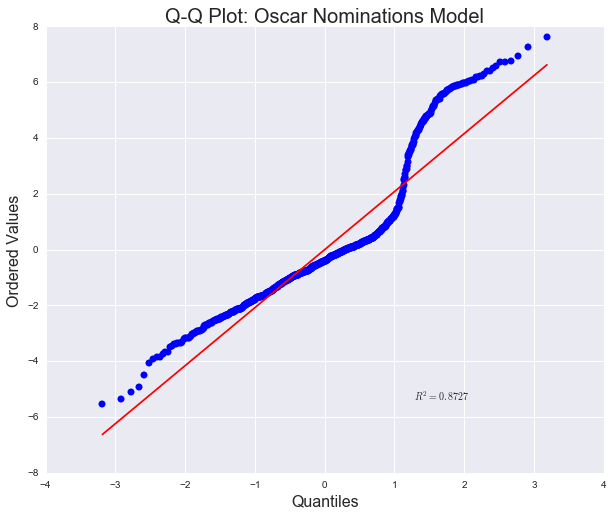

In [276]:
# qq plot with training set
otrain_resid, _, _ = validate(oscars, X, y, X, y)

plt.figure(figsize=(10, 8))
stats.probplot(otrain_resid, dist="norm", plot=plt)
plt.title('Q-Q Plot: Oscar Nominations Model', fontsize=20)
plt.xlabel('Quantiles', fontsize=16)
plt.ylabel('Ordered Values', fontsize=16)
plt.show()